### First, let's bring in some data.

In [1]:
# Imports and helper functions

import accidentHandler as aH
import numpy as np
import pandas as pd
import riskModelBuilder as rMB
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn import preprocessing as skpre
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.learning_curve import learning_curve
%matplotlib inline

/home/louisf/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/louisf/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Accident data.

In [ ]:
accdf = pd.read_csv('/home/louisf/Documents/Insight/massdriver/data/accidents_3yr', low_memory=False)

### Next, let's load in a post-imputed data set. We then add a new column which is the number of accidents.

In [ ]:
# roaddf = pd.read_csv('/home/louisf/Documents/Insight/massdriver/data/intermediateGraphDB.csv')
roaddf = pd.read_csv('/home/louisf/Documents/Insight/massdriver/data/imputedDF.csv')


In [ ]:
accdf['numaccidents']=1

In [ ]:
grouped = accdf.groupby(by="roadsegmentid")
numaccidents = grouped.agg(sum).numaccidents
numaccidents.index.name = 'roadsegmen'

In [ ]:
numaccidents

In [ ]:
df2 = roaddf.join(numaccidents, on='roadsegmen')
df2.numaccidents[pd.isnull(df2.numaccidents)] = 0

In [ ]:
df2['accidentspersegment']=df2['numaccidents']/df2['assignedle']

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.hist(df2.numaccidents, bins=300)
plt.yscale('log')
plt.title('Number of accidents per road segment')
plt.xlabel('Number of accidents')
plt.ylabel('Number of road segments')
plt.savefig('numberofAccidents.png', dpi=300)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.hist(df2.accidentspersegment, bins=np.logspace(0.1, 4,150 )) #pl.hist(data, bins=np.logspace(0.1, 1.0, 50))
plt.yscale('log')
plt.xscale('log')
plt.title('Accident rate per road segment')
plt.xlabel('Accident rate')
plt.ylabel('Number of road segments')
plt.savefig('rateofAccidents.png', dpi=300)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.hist(2+df2.accidentspersegment, bins=np.logspace(.1,4,150)) #pl.hist(data, bins=np.logspace(0.1, 1.0, 50))
plt.yscale('log')
plt.xscale('log')
plt.title('Accident rate per road segment')
plt.xlabel('Accident rate + 1')
plt.ylabel('Number of road segments')
plt.savefig('rateofAccidents.png', dpi=300)

### Now it's time to start assigning categorical variables to this mess.

In [ ]:
# Bring in the requirements document.
pathtoreqs = '/home/louisf/Documents/Insight/massdriver/docs/road_inventory_params.csv'
reqs = pd.read_csv(pathtoreqs, delimiter = '^')

In [ ]:
replaceMe = reqs[(reqs['Categorical']==True) & (reqs['Disqualify']==False)]
test = roaddf.copy()

In [ ]:
for variable in replaceMe.Variable:
    dummycat = pd.get_dummies(test[variable], prefix=variable)
    test.drop(variable, inplace=True, axis=1)
    test = test.join(dummycat, how='right')

In [ ]:
dropdisq = reqs[reqs['Disqualify']==True]
for var in dropdisq['Variable']:
    try:
        test.drop(var, inplace=True, axis=1)
    except ValueError:
        print("{} not found".format(var))

In [ ]:
# Alternate method: replace the string variables with numbers, not dummy variables.
# Random forest doesn't need dummy variables!
test = df2.copy()
r2 = reqs[reqs['Data type']=='string']
target = r2[r2['Disqualify']==False]

In [ ]:
# county

vals = [ord(char) - 64 for char in test['county']]

test['county']=vals

In [ ]:
# mpo

test.mpo.replace(to_replace={'Boston Region':1, 
                             'Northern Middlesex':2, 
                            'Southeastern Massachusetts':3, 
                            'Merrimack Valley':4, 
                            'Berkshire':5,
                            'Montachusett':6, 
                            'Pioneer Valley':7, 
                            "Martha's Vineyard":8, 
                            'Central Massachusetts':9, 
                            'Cape Cod':10, 
                            'Franklin':11,
                            'Old Colony':12,
                            'Nantucket':13}, 
                inplace=True)

In [ ]:
# rpa
test.rpa.replace(to_replace={'MAPC':1,
                             'NMCOG':2,
                             'SRPEDD':3,
                             'MVPC':4,
                             'BRPC':5,
                             'MRPC':6,
                             'PVPC':7,
                             'MVC':8,
                             'CMRPC':9,
                             'CCC':10,
                             'FRCOG':11,
                             'OCPC':12,
                             'NPEDC':13,
                             'MAPC-OCPC':14},
                inplace=True)


In [ ]:
# routesyste
test.routesyste.replace(to_replace={'L':1,
                                    np.nan:2,
                                    'R':3,
                                    'SR':4,
                                    'N':5,
                                    'US':6,
                                    'B':7,
                                    'I':8},
                       inplace=True)

In [ ]:
test.drop('fromstreet',inplace=True, axis=1)

In [ ]:
test.to_csv('~/Documents/Insight/massdriver/data/noncategoricalDF.csv')

###  Clear the memory here!

In [ ]:
del reqs
del roaddf
del grouped
del dropdisq

In [2]:
#catDF = pd.DataFrame.from_csv('~/Documents/Insight/massdriver/data/categoricalDF.csv')
catDF = pd.DataFrame.from_csv('~/Documents/Insight/massdriver/data/noncategoricalDF.csv')

In [ ]:
dummycat = pd.get_dummies(catDF['county'], prefix='county')
catDF.drop('county', inplace=True, axis=1)
catDF = catDF.join(dummycat, how='right')

dummycat = pd.get_dummies(catDF['city'], prefix='city')
catDF.drop('city', inplace=True, axis=1)
catDF = catDF.join(dummycat, how='right')


In [3]:
nparr = np.asarray(catDF)

In [4]:
colnames = catDF.columns
print(colnames[0])
print(colnames[7])
print(colnames[39])
print(colnames[61])
print(colnames[62])

Unnamed: 0.1
assignedle
roadsegmen
numaccidents
accidentspersegment


### Predict!

In [5]:
m = rMB.Model()

In [6]:
# Split up the data 
colnames = catDF.columns
test_size = 0.2

# CURRENTLY LEAVING IN assignedle
coltodropCAT = [0, 7, 37, 59, 60] # don't consider unnamed index, roadsegmen, numaccidents, accidentspersegment 38, 43,
coltodrop = [0, 7, 39, 61, 62]
X = np.delete(nparr, coltodrop, axis=1)
# X = X[1:20000,:]
y = np.log(1+nparr[:,62])
# y = y[1:20000]
x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state = 127)

del nparr

In [7]:
colnames = list(catDF.columns.values)
for i in sorted(coltodrop, reverse=True):
    del colnames[i]

In [11]:
n_estimators = np.linspace(375,600,10)
#n_estimators = [20]
scores = []
oob_scores = []
rf_preds = []
xvs = []
yvs = []
rfs = []

for n in n_estimators:
    score, oob_score, rf_pred, _, _, rf = m.rf_regression(x_train, y_train, int(n), .3, 4)
    scores.append(score)
    oob_scores.append(oob_score)
    # rfs.append(rf)
    print('n estimators: {} completed'.format(n))

n estimators: 375.0 completed
n estimators: 400.0 completed
n estimators: 425.0 completed
n estimators: 450.0 completed
n estimators: 475.0 completed
n estimators: 500.0 completed
n estimators: 525.0 completed
n estimators: 550.0 completed
n estimators: 575.0 completed
n estimators: 600.0 completed


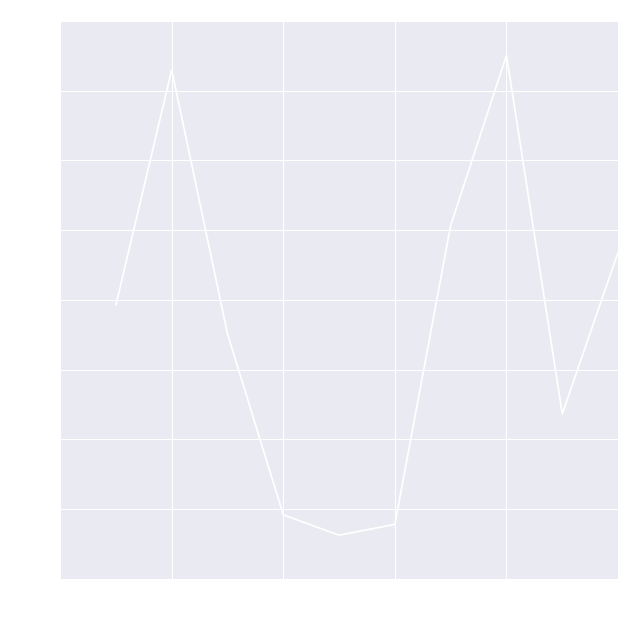

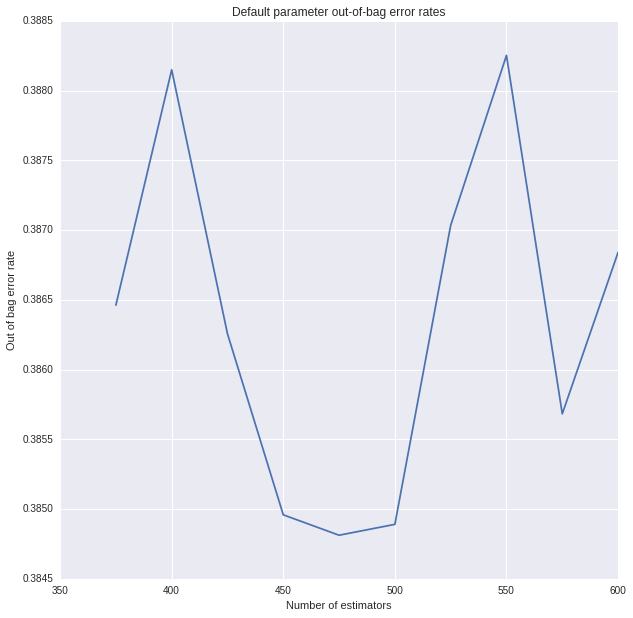

In [12]:
fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(111)
plt.plot(n_estimators, oob_scores, 'w')
plt.title("Default parameter out-of-bag error rates", color='w')
plt.xlabel("Number of estimators", color='w')
plt.ylabel("Out of bag error rate", color='w')
[i.set_color("w") for i in plt.gca().get_xticklabels()]
[i.set_color("w") for i in plt.gca().get_yticklabels()]
#plt.savefig('estimator_search.png',transparent=True)

fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(111)
plt.plot(n_estimators, oob_scores)
plt.title("Default parameter out-of-bag error rates")
plt.xlabel("Number of estimators")
plt.ylabel("Out of bag error rate")
#[i.set_color("w") for i in plt.gca().get_xticklabels()]
#[i.set_color("w") for i in plt.gca().get_yticklabels()]
#plt.savefig('estimator_search_readable.png')



In [16]:
oob_scores

[0.38646187720406311,
 0.38814876336987225,
 0.38625620235910552,
 0.38495864252506606,
 0.38481238828292696,
 0.38489029268282227,
 0.38703376564021452,
 0.38825218763981773,
 0.38568241254153879,
 0.38684011226394777]

In [8]:
n_estimators = np.linspace(25,400,16)
#n_estimators = [20]
scores = []

#Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'bootstrap': True, 'min_samples_split': 13, 'max_features': 0.1}
#predicted, scores = m.rf_regression_crossval(x_train, y_train, 100, 5, 4)
rf = RandomForestRegressor(n_estimators=250, oob_score=True, n_jobs=4, max_depth = None,
                      min_samples_leaf = 4, bootstrap = True,
                      min_samples_split = 13, max_features = 0.1)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.1, max_leaf_nodes=None, min_samples_leaf=4,
           min_samples_split=13, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=4, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [9]:
predy = rf.predict(x_test)
spred = rf.score(x_test, predy)
strue = rf.score(x_test, y_test)
print(strue)

0.430601525387


In [20]:
import scipy.stats as stats

t,p = stats.ttest_ind(y_test, predy, equal_var=False)
print(p)

0.853458097933


In [22]:
t

-0.18470826708353574

In [10]:
score = rf.score(x_test, y_test)
ypred = rf.predict(x_test)

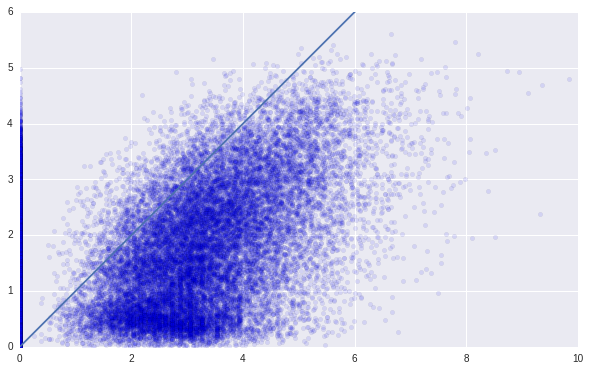

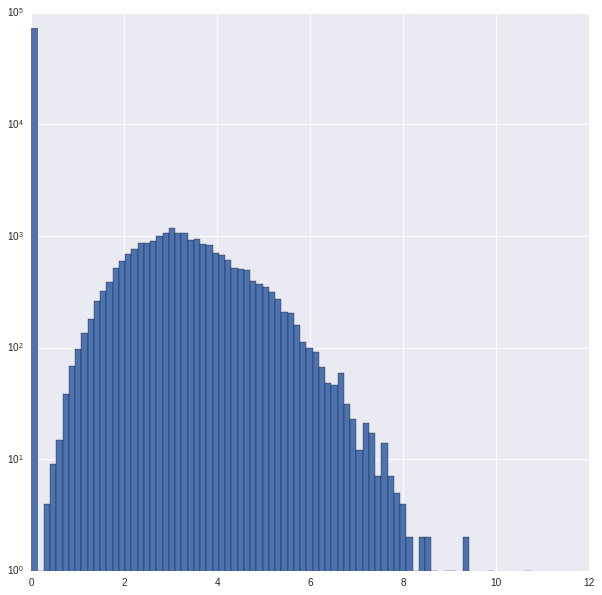

In [12]:
x = np.linspace(0, 10)
y = np.linspace(0, 10)
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y, '-')
plt.scatter(y_test, ypred, alpha=0.1)
plt.xlim((0, 10))
plt.ylim((0, 6))

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
plt.hist(y_test, bins=80)
plt.yscale('log')

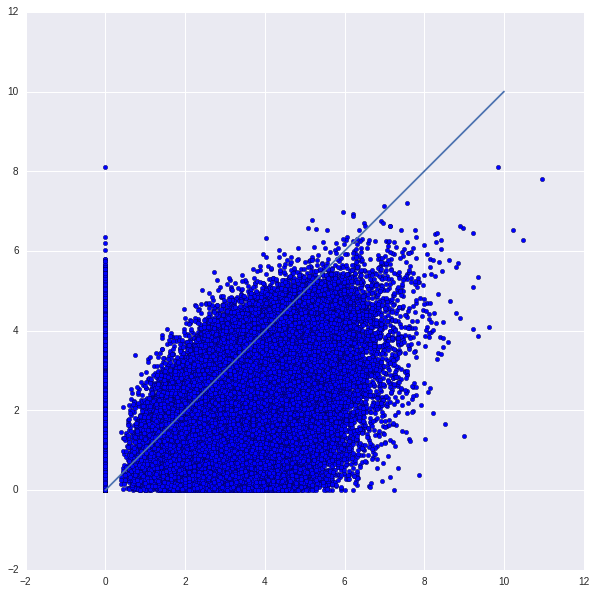

In [12]:
x = np.linspace(0, 10)
y = np.linspace(0, 10)
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y, '-')
plt.scatter(y_train, predicted)

In [ ]:
rf.feature_importances_

In [ ]:
plt.errorbar(train_sizes, np.mean(train_scores, axis=1), np.std(train_scores, axis=1))
plt.errorbar(train_sizes, np.mean(test_scores, axis=1), np.std(test_scores, axis=1))
plt.xlabel("Number of samples used")
plt.ylabel("R$^2$")
plt.title("Learning curve for 250 estimators, default parameters, RF")
plt.savefig('RF_n100_defaults_learning_curve.png')

### Let's use a copy-paste approach to tune parameters

In [17]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
X, y = x_train, y_train

# build a classifier
clf = RandomForestRegressor(n_estimators=250, n_jobs=4)


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [5, 16, None],
              "max_features": [0.1, 0.2, 0.3, 0.5, 0.75, 1.0],
              "min_samples_split": sp_randint(1, 30),
              "min_samples_leaf": sp_randint(1, 30),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

"""# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 10, 20],
              "min_samples_split": [1, 10, 20],
              "min_samples_leaf": [1, 10, 20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)"""

RandomizedSearchCV took 7306.42 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.417 (std: 0.002)
Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'bootstrap': False, 'min_samples_split': 15, 'max_features': 0.1}

Model with rank: 2
Mean validation score: 0.414 (std: 0.002)
Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'bootstrap': True, 'min_samples_split': 13, 'max_features': 0.1}

Model with rank: 3
Mean validation score: 0.411 (std: 0.002)
Parameters: {'max_depth': 16, 'min_samples_leaf': 4, 'bootstrap': True, 'min_samples_split': 4, 'max_features': 0.5}



'# use a full grid over all parameters\nparam_grid = {"max_depth": [3, None],\n              "max_features": [1, 10, 20],\n              "min_samples_split": [1, 10, 20],\n              "min_samples_leaf": [1, 10, 20],\n              "bootstrap": [True, False],\n              "criterion": ["gini", "entropy"]}\n\n# run grid search\ngrid_search = GridSearchCV(clf, param_grid=param_grid)\nstart = time()\ngrid_search.fit(X, y)\n\nprint("GridSearchCV took %.2f seconds for %d candidate parameter settings."\n      % (time() - start, len(grid_search.grid_scores_)))\nreport(grid_search.grid_scores_)'

In [ ]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)

Feature ranking:


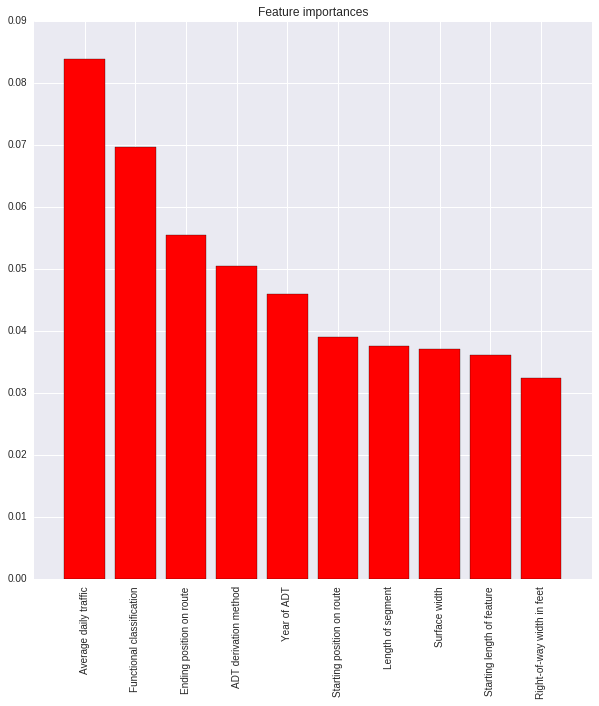

In [53]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

si = importances[indices]
plt.title("Feature importances")
plt.bar(range(0,10), si[0:10],
       color="r", align="center")
plt.xticks(range(0,10), nicenames, rotation='vertical')
plt.xlim([-1, 10])


plt.savefig('feature_importances.png')

In [46]:
[colnames[2], colnames[15], 
 colnames[39], colnames[3], 
 colnames[4], colnames[37], 
 colnames[42], colnames[47], 
 colnames[51], colnames[33]]

['adt',
 'functional',
 'routeto',
 'adtderivat',
 'adtyear',
 'routefrom',
 'shape_len',
 'surfacewid',
 'tomeasure',
 'rightofway']

In [48]:
nicenames = ['Average daily traffic', 
'Functional classification',
'Ending position on route',
'ADT derivation method',
'Year of ADT',
'Starting position on route',
'Length of segment',
'Surface width',
'Starting length of feature',
'Right-of-way width in feet']

In [14]:
si = importances[indices]

In [ ]:
from scipy.stats import randint as sp_randint
sp_randint(1,100)/100

In [ ]:
# Perform 5 fold cross validation during training

predicted = m.rf_regression_crossval(x_train, y_train, 100, 5)

In [ ]:
metrics.r2_score(y_train, predicted)

In [ ]:
m.linear_crossval(x_train, y_train, 5)